<a href="https://colab.research.google.com/github/SakanaAI/asal/blob/main/asal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automating the Search for Artificial Life with Foundation Models

Automated Search for Artificial Life (ASAL) is an algorithm to automatically discover interesting ALife simulations!

Rather than hand designing a particular simulation, just parameterize a big set of simulations (e.g. all Lenia simulations) and automatically search over them.

This notebook will show you how to 
1) Search for supervised target simulations specified by a single prompt
2) Search for supervised target simulations specified by multiple temporal prompts
3) Search for open-ended simulations
4) Illuminate the entire substrate by finding a diverse set of simulations

Then, we will show you how to play around with other substrates we have implemented.

Finally, we will show you how to load in the existing organims found from our large scale searches.



In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [ ]:
# ------------------------RUN THIS BLOCK ONLY IF YOU ARE RUNNING IN GOOGLE COLAB------------------------
! git clone https://github.com/SakanaAI/asal.git
sys.path.append(os.path.abspath("./asal"))

In [2]:
import os, sys, glob, pickle
from functools import partial

import jax
import jax.numpy as jnp
from jax.random import split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

import substrates
import foundation_models
from rollout import rollout_simulation
import asal_metrics
import util


## Supervised Target (Single Target)

To begin, let's search for a Lenia simulation which produces a final state matching a single prompt `"a caterpillar"`.

Run this command:

In [3]:
! python main_opt.py --seed=0 --save_dir="./data/st_0" --substrate='lenia' --time_sampling=1 --prompts="a caterpillar" --coef_prompt=1. --coef_softmax=0. --coef_oe=0. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

Namespace(seed=0, save_dir='./data/st_0', substrate='lenia', rollout_steps=None, foundation_model='clip', time_sampling=1, prompts='a caterpillar', coef_prompt=1.0, coef_softmax=0.0, coef_oe=0.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
2024-12-28 06:17:37.744208: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
ParameterReshaper: 3117 parameters detected for optimization.
100%|█████████████████████| 1000/1000 [01:21<00:00, 12.26it/s, best_loss=-0.307]


In [4]:
save_dir = "./data/st_0"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('lenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

2024-12-28 06:19:15.306717: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


ParameterReshaper: 3117 parameters detected for optimization.


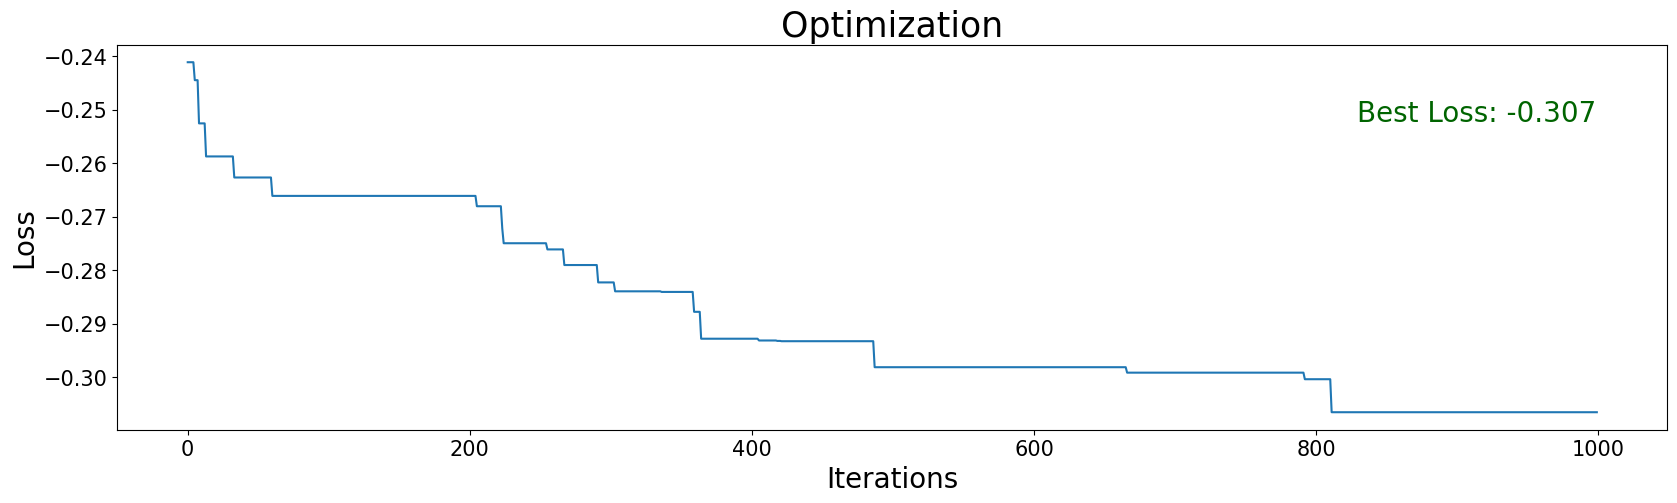

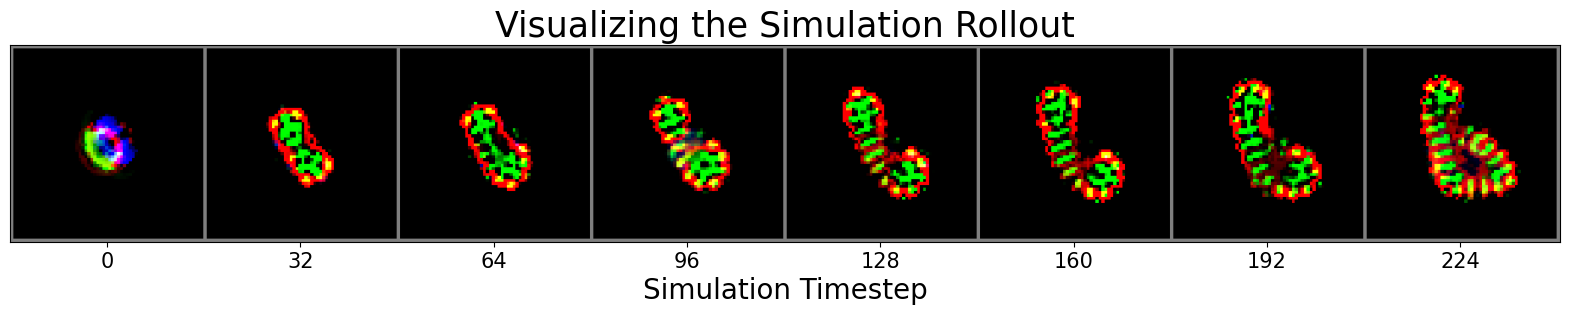

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

## Supervised Target (Temporal Targets)

Now, let's search for a Lenia simulation which produces a trajectory going from `"a single cell"` to `"a diverse ecosystem of cells"`.

Although not required, it sometimes helps to include + tune the coef_softmax parameter below to incentivize the simulation to find unique images for each prompt rather than one static image satisfying both prompts.

Run this command:

In [3]:
! python main_opt.py --seed=3 --save_dir="./data/st_temp_3" --substrate='lenia' --time_sampling=2 --prompts="one biological cell;two biological cells" --coef_prompt=1. --coef_softmax=1. --coef_oe=0. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

Namespace(seed=3, save_dir='./data/st_temp_3', substrate='lenia', rollout_steps=None, foundation_model='clip', time_sampling=2, prompts='one biological cell;two biological cells', coef_prompt=1.0, coef_softmax=1.0, coef_oe=0.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
2024-12-28 06:20:26.410585: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
ParameterReshaper: 3117 parameters detected for optimization.
100%|█████████████████████| 1000/1000 [01:24<00:00, 11.87it/s, best_loss=-0.139]


In [4]:
save_dir = "./data/st_temp_3"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('lenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

2024-12-28 06:22:07.537743: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


ParameterReshaper: 3117 parameters detected for optimization.


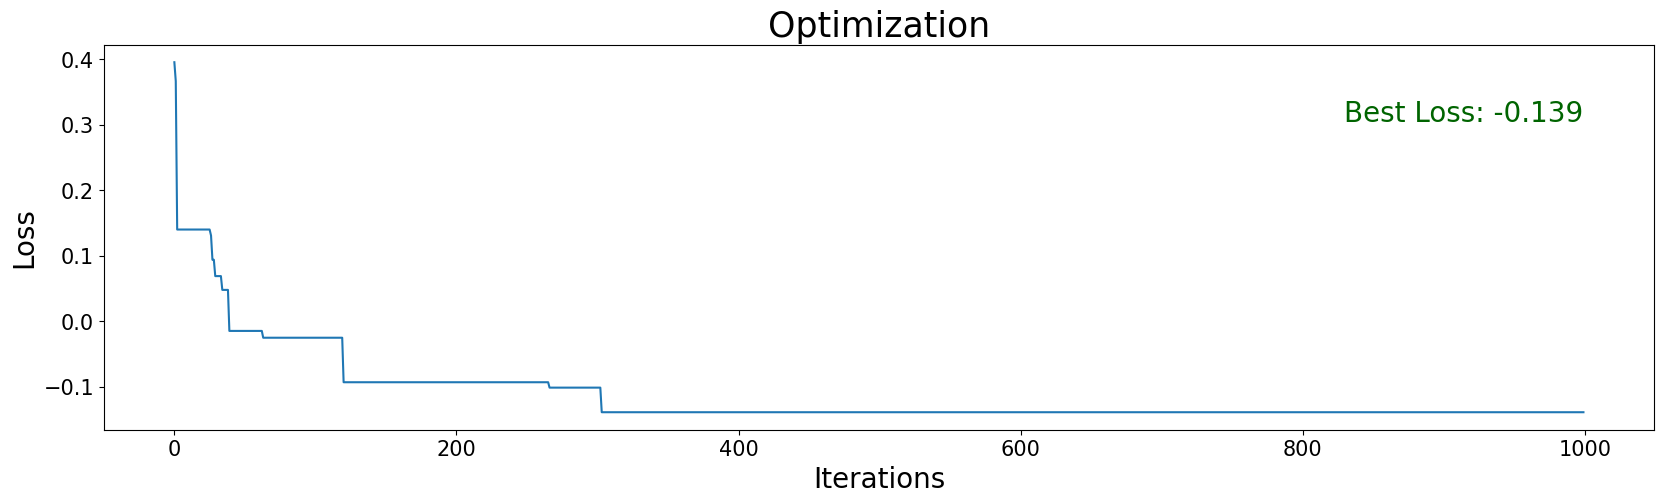

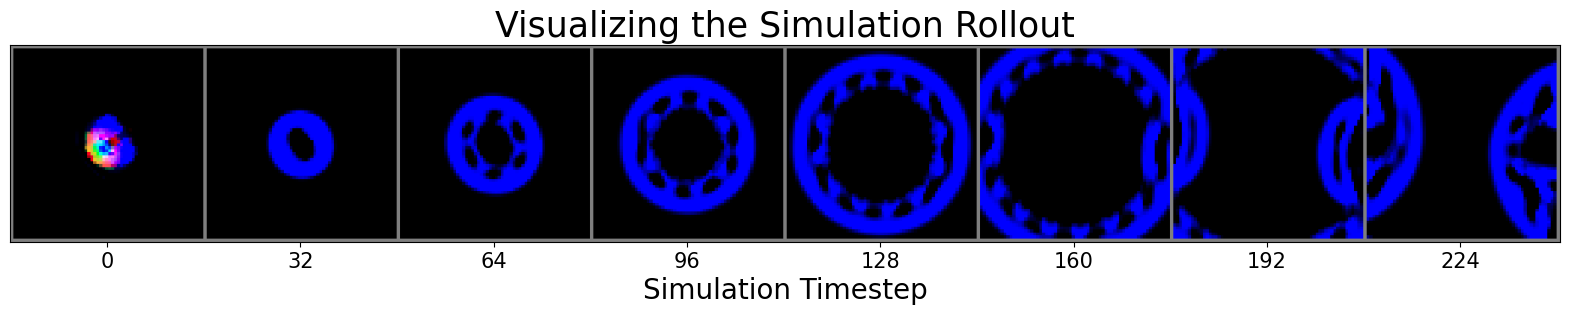

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

## Open-Endedness

Great! Now let's discover a Lenia simulation which is open-ended, meaning it generates novelty in time.

Run this command:

In [ ]:
! python main_opt.py --seed=3 --save_dir="./data/oe_3" --substrate='lenia' --time_sampling=32 --prompts="" --coef_prompt=0. --coef_softmax=0. --coef_oe=1. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

/home/akarsh_sakana_ai/.conda/envs/asal_test/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Namespace(seed=0, save_dir='./data/oe_0', substrate='lenia', rollout_steps=None, foundation_model='clip', time_sampling=32, prompts='', coef_prompt=0.0, coef_softmax=0.0, coef_oe=1.0, bs=1, pop_size=16, n_iters=1000, sigma=0.1)
^C
Traceback (most recent call last):
  File "/home/akarsh_sakana_ai/asal/main_opt.py", line 109, in <module>
    main(parse_args())
  File "/home/akarsh_sakana_ai/asal/main_opt.py", line 55, in main
    fm = foundation_models.create_foundation_model(args.foundation_model)
  File "/home/akarsh_sakana_ai/asal/foundation_models/__init__.py", line 19, in create_foundation_model
    fm = CLIP()
  File "/home/akarsh_sakana_ai/asal/foundation_models/clip.py", line 11, in __init__
    self.clip_model = FlaxCLIPModel.from_pretrained(f"openai/{clip_model}")
  File "/home/akarsh_sakana_ai/.conda/envs/asal_test/lib/python3.10/site-packages/transformers/modeling_flax_utils.py", line 689, in from_pretrained
    config, model_kwargs = cls.config_class.from_pretrained(
  File 

In [20]:
save_dir = "./data/oe_3"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('lenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 3117 parameters detected for optimization.


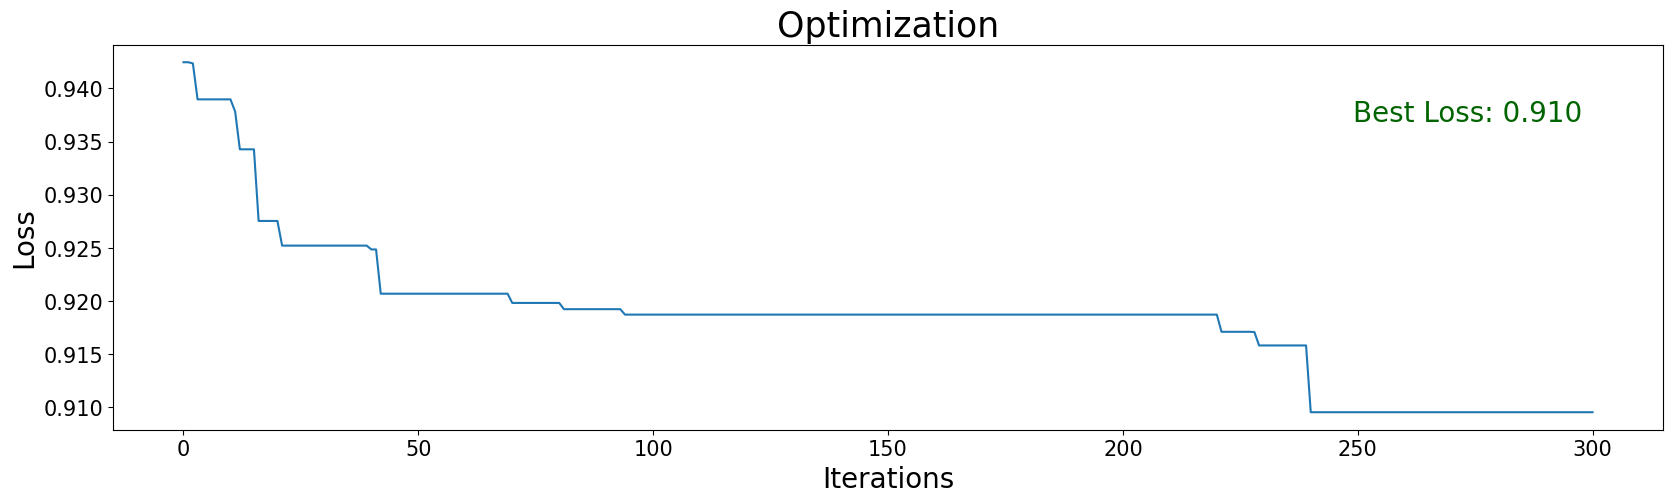

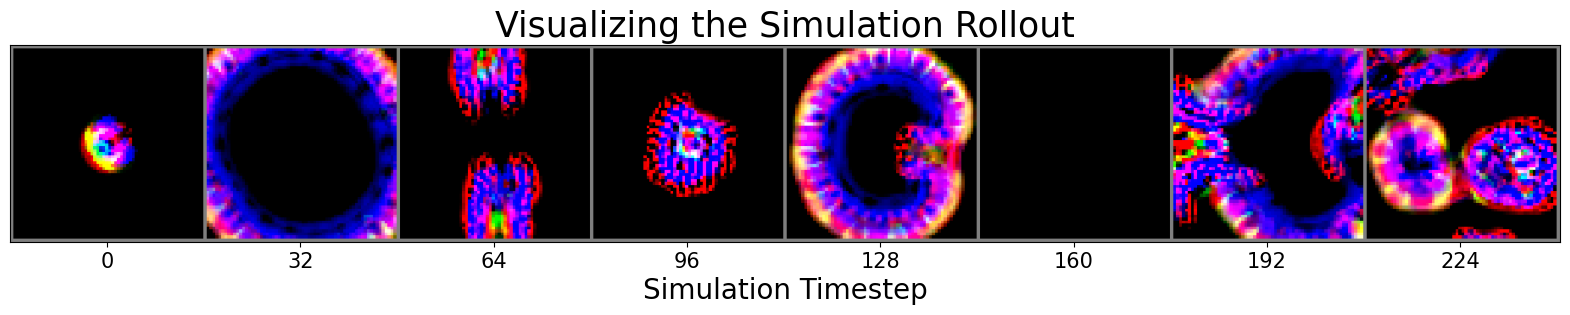

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

## Supervised Target + Open-Endedness

What if we combine the supervised target and open-endedness scores to optimize for?
Can we find an open-ended `"diverse ecosystem of cells"`?

Let's try it!

In [ ]:
! python main_opt.py --seed=0 --save_dir="./data/oest_0" --substrate='lenia' --time_sampling=32 --prompts="a diverse ecosystem of cells" --coef_prompt=1. --coef_softmax=0. --coef_oe=1. --bs=1 --pop_size=16 --n_iters=1000 --sigma=0.1

In [22]:
save_dir = "./data/oest_0"
data = util.load_pkl(save_dir, "data") # load optimization data
params, best_loss = util.load_pkl(save_dir, "best") # load the best parameters found

# fm = foundation_models.create_foundation_model('clip') # we don't need the foundation model for just the rollout currently
substrate = substrates.create_substrate('lenia') # create the substrate
substrate = substrates.FlattenSubstrateParameters(substrate) # useful wrapper to flatten the substrate parameters

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling=8, img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = rollout_fn(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 3117 parameters detected for optimization.


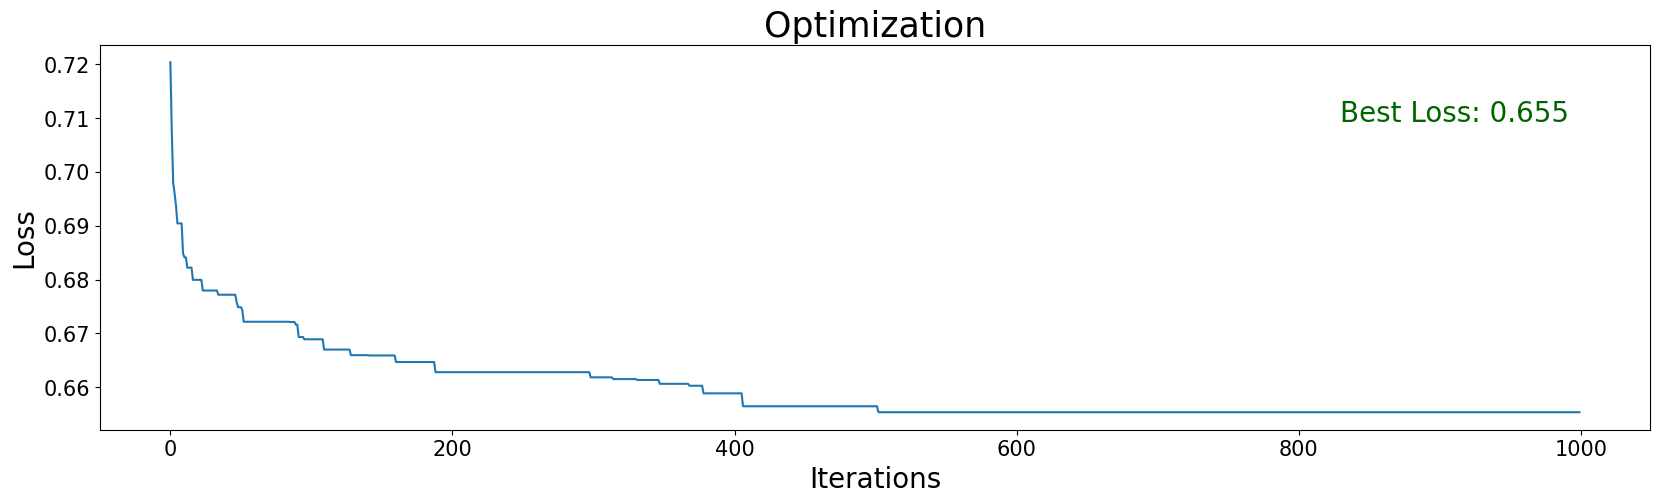

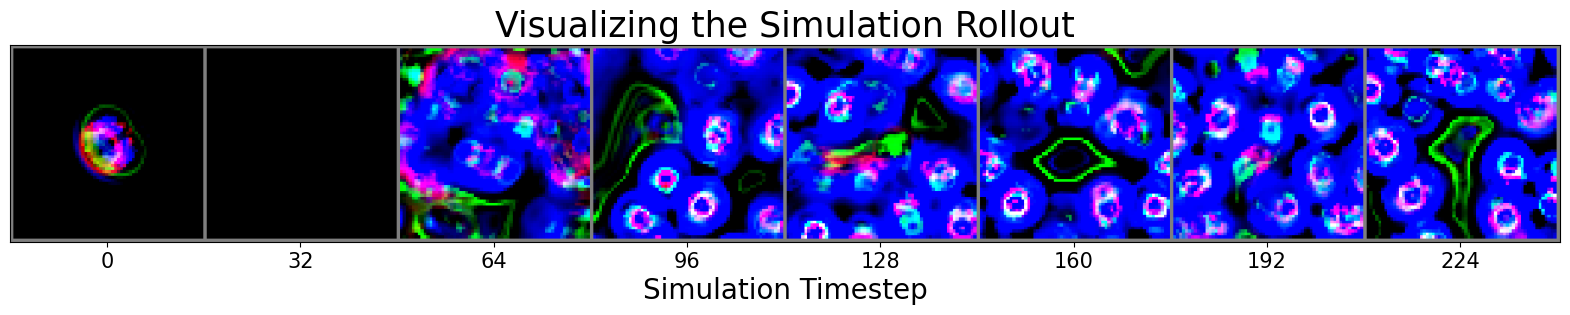

In [23]:
plt.figure(figsize=(20, 5))
plt.plot(data['best_loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "T H W D -> H (T W) D")
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks(np.arange(0, 8)*228+228//2, np.arange(0, 8)*substrate.rollout_steps//8, fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing the Simulation Rollout", fontsize=25)
plt.xlabel("Simulation Timestep", fontsize=20)
plt.show()

## Illumination

Great! Now let's try illuminating the entire Lenia substrate and find a diverse set of Lenia creatures!

Run this command in the terminal:

In [ ]:
! python main_illuminate.py --seed=0 --save_dir="./data/illuminate_0" --substrate='lenia' --n_child=32 --pop_size=256 --n_iters=1000 --sigma=0.1

In [27]:
data = util.load_pkl("./data/illuminate_0", "data") # load optimization data
pop = util.load_pkl("./data/illuminate_0", "pop") # load the best parameters found
params = pop['params']

# fm = foundation_models.create_foundation_model('clip')
substrate = substrates.create_substrate('lenia')
substrate = substrates.FlattenSubstrateParameters(substrate)

rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling='final', img_size=224, return_state=False)
rollout_fn = jax.jit(rollout_fn)

rng = jax.random.PRNGKey(0)
rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params) # rollout the simulation using this rng seed and simulation parameters

ParameterReshaper: 3117 parameters detected for optimization.


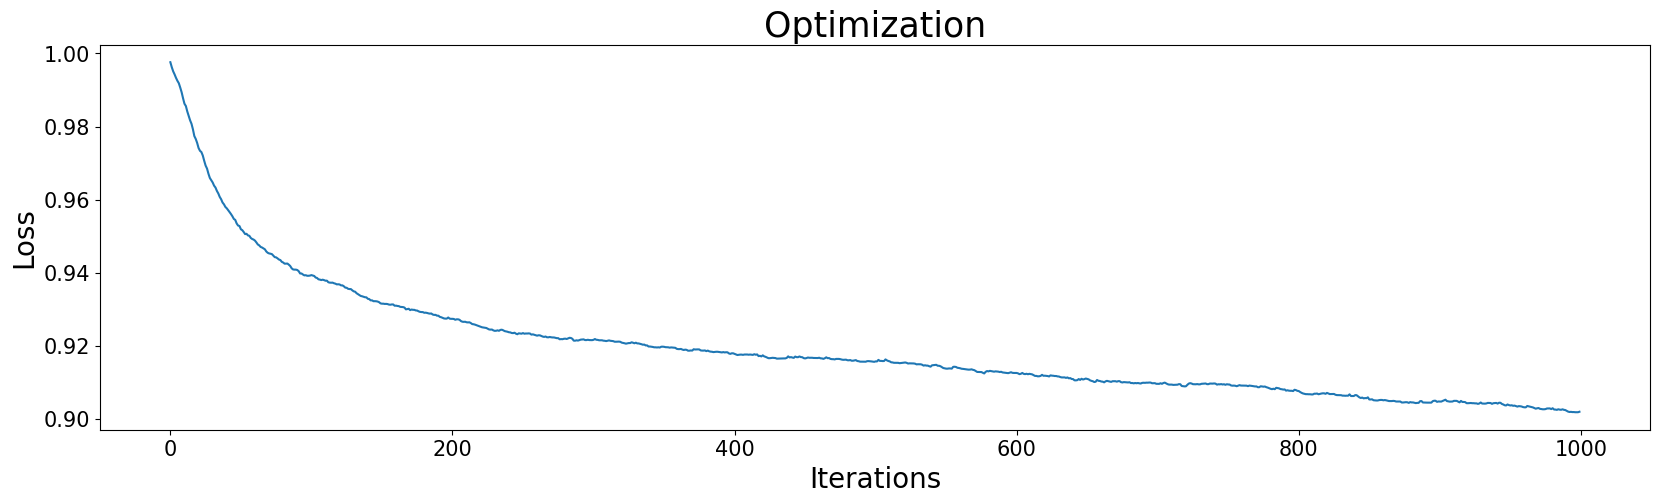

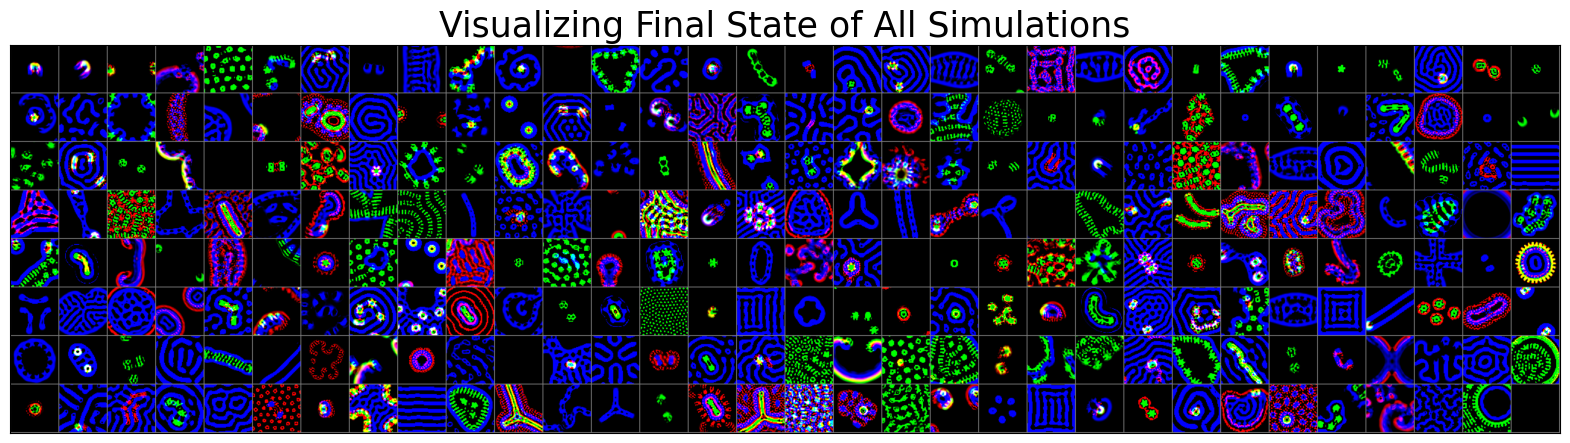

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(data['loss'])
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.title("Optimization", fontsize=25)
# plt.text(0.8, 0.8, f"Best Loss: {best_loss:.3f}", color='darkgreen', fontsize=20, transform=plt.gca().transAxes)
plt.show()

plt.figure(figsize=(20, 6))
img = np.array(rollout_data['rgb'])
img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
img = rearrange(img, "(R C) H W D -> (R H) (C W) D", R=8)
img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
plt.imshow(img)
plt.xticks([], fontsize=15); plt.yticks([], fontsize=15)
plt.title("Visualizing Final State of All Simulations", fontsize=25)
plt.show()

## Other substrates!

Above, we only showed results on Lenia because it runs the fastest, but feel free to run on other substrates as well!
We have implemented the following substrates already:
- [Lenia](https://en.wikipedia.org/wiki/Lenia)
- [Boids](https://en.wikipedia.org/wiki/Boids)
- [Particle Life](https://www.youtube.com/watch?v=scvuli-zcRc)
- Particle Life++ (Particle Life with changing color dynamics)
- [Particle Lenia](https://google-research.github.io/self-organising-systems/particle-lenia/)
- Discrete Neural Cellular Automata
- [Continuous Neural Cellular Automata](https://distill.pub/2020/growing-ca/)
- [Game of Life/Life-Like Cellular Automata](https://en.wikipedia.org/wiki/Life-like_cellular_automaton)

The following block visualizes random simulation parameters in each of these substrates.

Feel free to explore how you feel like now!
You can 
- find supervised target simulations in Boids
- or illuminate all Discrete NCA substrate
- or find open-ended Particle Life++ simulations
- or any combination you want!

Note that Game of Life will not work with the above scripts, because it is a discrete search space.
For sweeping Game of Life, check out the `main_sweep_gol.py` script.

Particle Life++ has lots of potential and is an extremely untapped substrate so far, so experimenting with that would be very cool, although optimization is hard in that, due to how chaotic it is.

If you get bored, it would be amazing to apply ASAL to newer substrates like [ALIEN](https://www.youtube.com/watch?v=qwbMGPkoJmg) and [JaxLife](https://github.com/luchris429/jaxlife)!

ParameterReshaper: 3117 parameters detected for optimization.


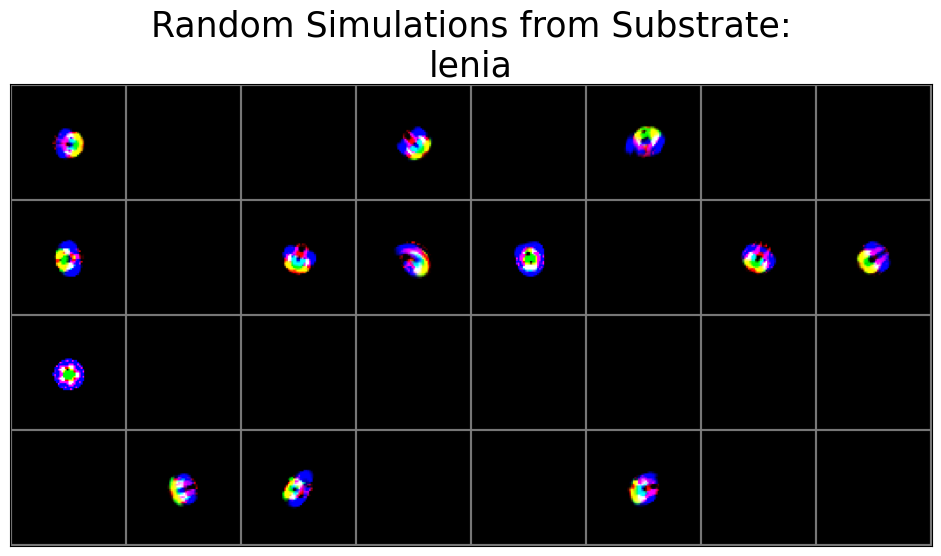

ParameterReshaper: 193 parameters detected for optimization.


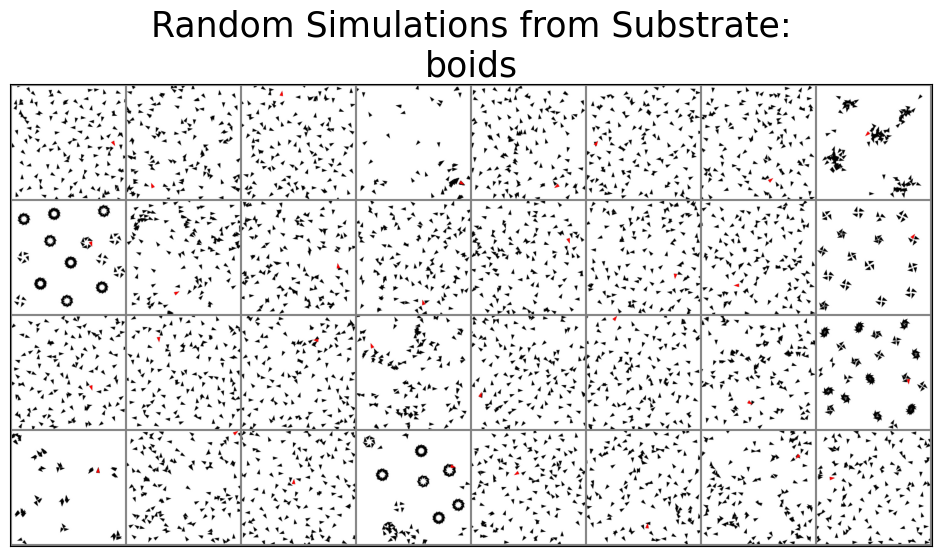

ParameterReshaper: 42 parameters detected for optimization.


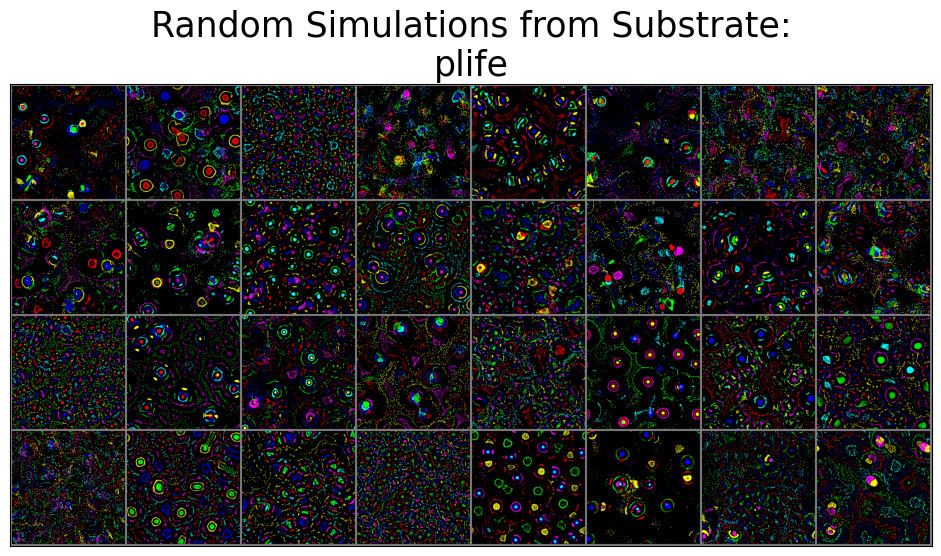

ParameterReshaper: 311 parameters detected for optimization.


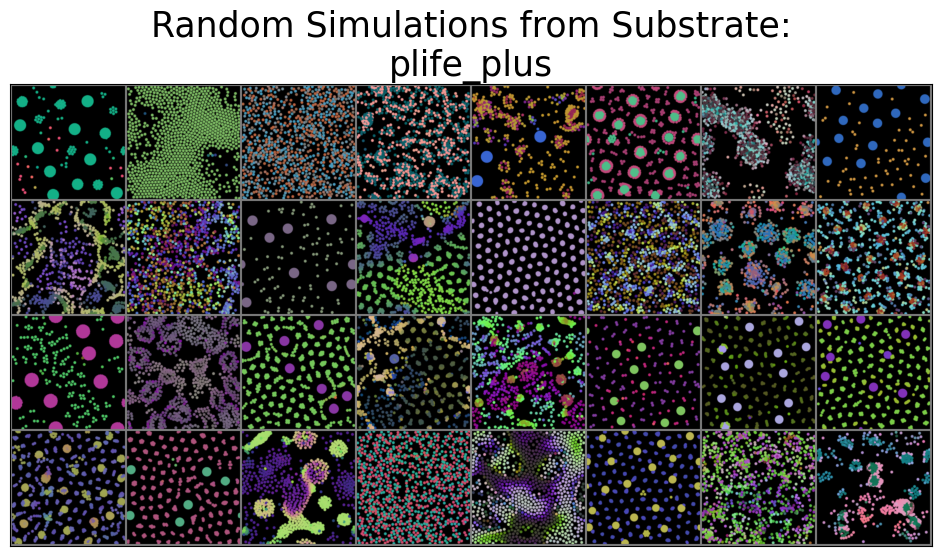

ParameterReshaper: 6 parameters detected for optimization.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


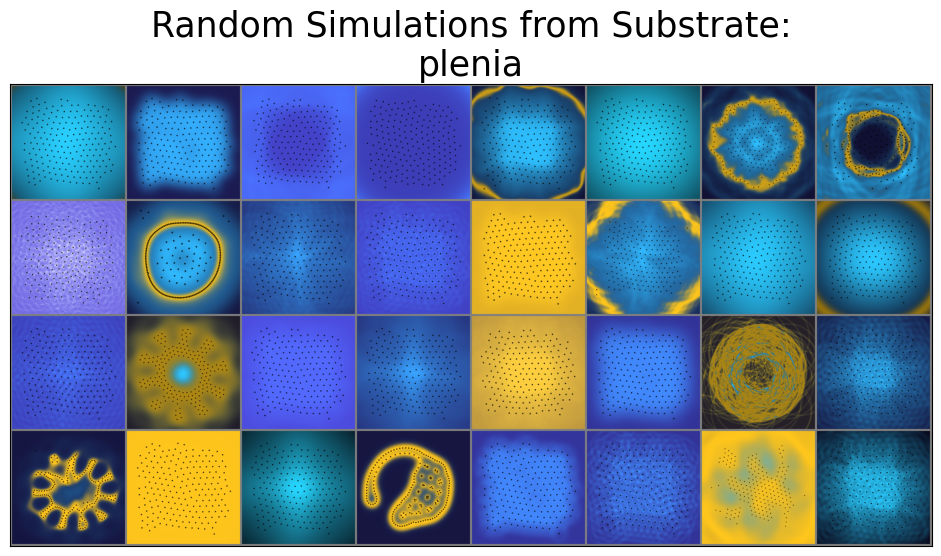

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


ParameterReshaper: 588 parameters detected for optimization.


E1228 06:28:03.006817 3246604 gpu_timer.cc:89] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E1228 06:28:03.115966 3246604 gpu_timer.cc:89] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


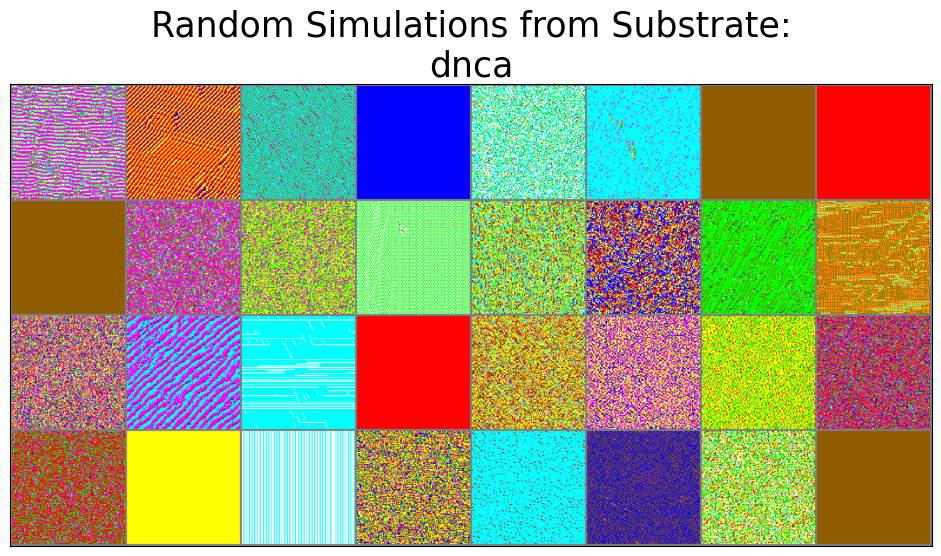

ParameterReshaper: 209 parameters detected for optimization.


E1228 06:28:06.052109 3246604 gpu_timer.cc:89] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E1228 06:28:06.161034 3246604 gpu_timer.cc:89] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


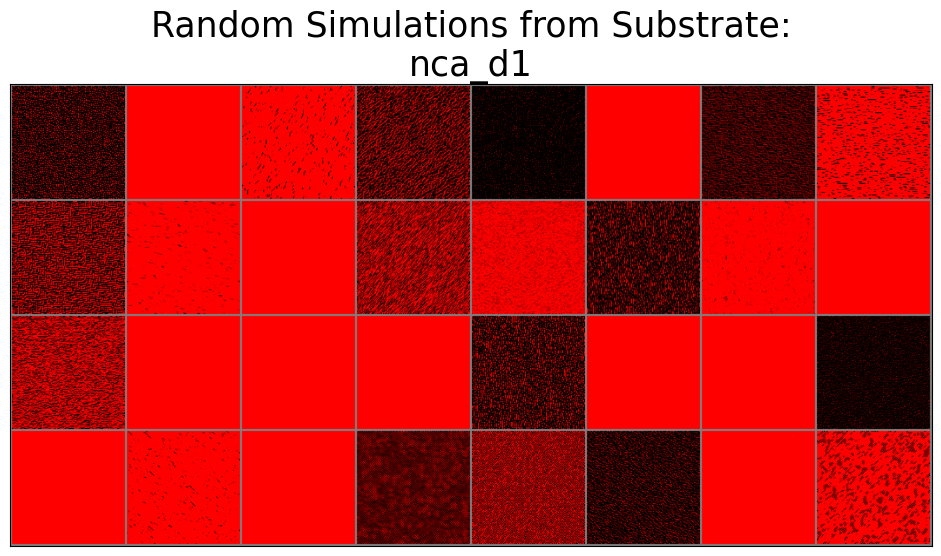

ParameterReshaper: 315 parameters detected for optimization.


E1228 06:28:09.097671 3246604 gpu_timer.cc:89] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E1228 06:28:09.206614 3246604 gpu_timer.cc:89] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


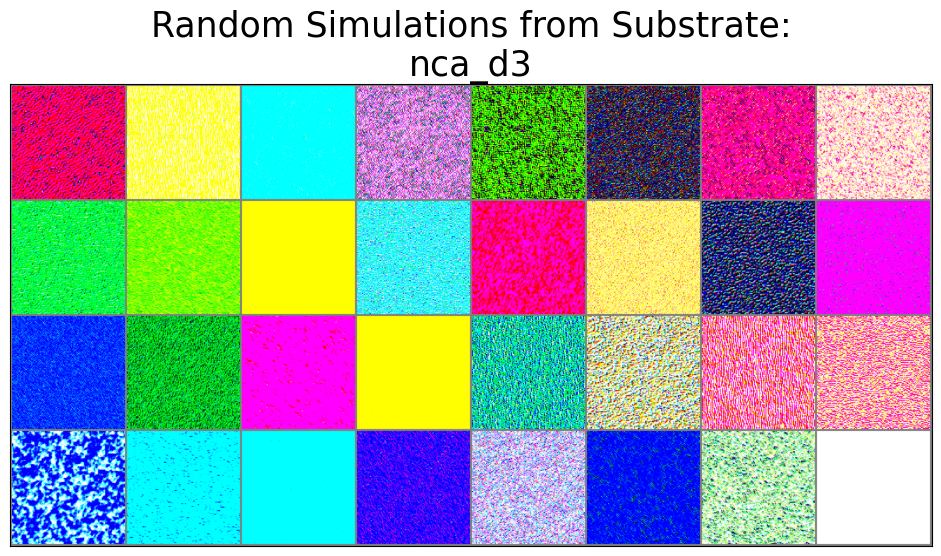

ParameterReshaper: 1 parameters detected for optimization.


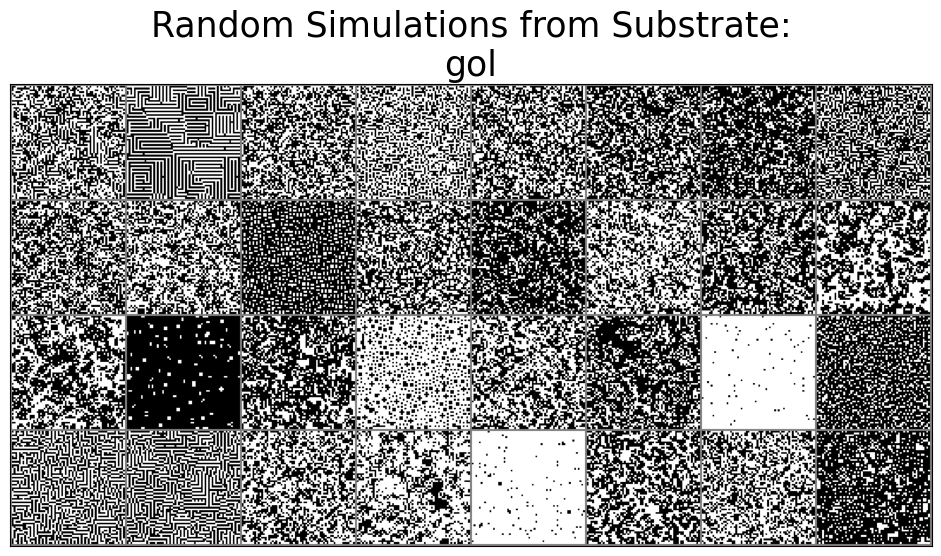

In [29]:
for substrate_name in ['lenia', 'boids', 'plife', 'plife_plus', 'plenia', 'dnca', 'nca_d1', 'nca_d3', 'gol']: # loop over substrates

    substrate = substrates.create_substrate(substrate_name)
    substrate = substrates.FlattenSubstrateParameters(substrate)

    rollout_fn = partial(rollout_simulation, s0=None, substrate=substrate, fm=None, rollout_steps=substrate.rollout_steps, time_sampling='final', img_size=224, return_state=False)
    rollout_fn = jax.jit(rollout_fn)

    rng = jax.random.PRNGKey(0)
    params = jax.vmap(substrate.default_params)(split(rng, 32)) # sample some random simulation parameters

    rollout_data = jax.vmap(rollout_fn, in_axes=(None, 0))(rng, params) # rollout the simulation using this rng seed and simulation parameters

    img = np.array(rollout_data['rgb'])
    img = np.pad(img, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.5)
    img = rearrange(img, "(R C) H W D -> (R H) (C W) D", R=4)
    img = np.pad(img, ((2, 2), (2, 2), (0, 0)), constant_values=0.5)
    plt.figure(figsize=(20, 6))
    plt.imshow(img)
    plt.xticks([], fontsize=15); plt.yticks([], fontsize=15)
    plt.title(f"Random Simulations from Substrate:\n{substrate_name}", fontsize=25)
    plt.show()